<a href="https://colab.research.google.com/github/AryanJadhao/Vision-Language-Model/blob/main/smolVLM_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install trl

In [2]:
import transformers
import trl

import torch

from transformers import BitsAndBytesConfig

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Using device: {device}")


[INFO] Using device: cuda


In [3]:
from datasets import load_dataset
from PIL import Image

dataset = load_dataset("mrdbourke/FoodExtract-1k-Vision")
dataset

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/280M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1510 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image_name', 'food101_class_name', 'food101_split', 'image_source', 'qwen3_vl_8b_yaml_out', 'qwen3_vl_inference_time', 'output_label_json', 'is_food', 'image'],
        num_rows: 1510
    })
})

In [4]:
dataset.shape

{'train': (1510, 10)}

In [5]:
example_sample = dataset["train"][0]

example_sample

{'image_id': '3233632',
 'image_name': '3233632.jpg',
 'food101_class_name': 'cheese_plate',
 'food101_split': 'train',
 'image_source': 'food101',
 'qwen3_vl_8b_yaml_out': 'point_of_view: 45-degree\ndishes:\n  - cheese plate\nfood_items:\n  - cheese wedge\n  - toast\n  - herb garnish\n  - dipping sauce\ndrink_items: []\ncontainers_and_utensils:\n  - white plate\n  - small white bowl\nattributes:\n  - sliced\n  - garnished\n  - served with accompaniments',
 'qwen3_vl_inference_time': 1.6110260486602783,
 'output_label_json': {'is_food': 1,
  'image_title': 'cheese plate',
  'food_items': ['toast', 'herb garnish', 'dipping sauce', 'cheese wedge'],
  'drink_items': []},
 'is_food': 1,
 'image': <PIL.Image.Image image mode=RGB size=512x512>}

[INFO] Example desired output:
{'is_food': 1, 'image_title': 'cheese plate', 'food_items': ['toast', 'herb garnish', 'dipping sauce', 'cheese wedge'], 'drink_items': []}
[INFO] Example image input:


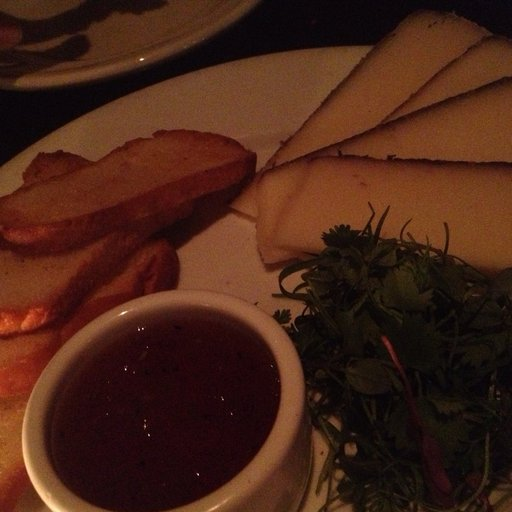

In [6]:
example_input = example_sample["image"]
example_output = example_sample["output_label_json"]

print(f"[INFO] Example desired output:\n{example_output}")

print(f"[INFO] Example image input:")
example_input

# Format data for use with a VLM

Our VLM input requires our data to be formatted in a conversational style.

In [7]:
# System message
SYSYTEM_MESSAGE = """You are an expert food and drink image extractor.
You provide structured data to visual inputs classifying them as edible food/drink or not.
As well as titling the image with a simple food/drink related caption.
Finally you extract any and all visible food/drink items to lists.
"""

# User prompt with image input as well as desired output
USER_PROMPT = """Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.

Only return valid JSON in the following form:

```json
{
  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)
  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present
  'food_items': [], # list[str] - list of visible edible food item nouns
  'drink_items': [] # list[str] - list of visible edible drink item nouns
}
```
"""

# Create helper function to map our input/output samples to conversational format
def format_data(sample):
    return {
        "messages": [

            # Message 0 - [SYSTEM] System Prompt (setting the scene)
            {
                "role": "system",
                "content": [{"type": "text", "text": SYSYTEM_MESSAGE}]
            },

            # Message 1 - [USER] User input (image + prompt pair)
            {
                "role": "user",
                "content": [
                    {
                        "type": "image",
                        "image": sample["image"],
                    },
                    {
                        "type": "text",
                        "text": USER_PROMPT # Note: In a future extension, you might train the model to not require any text input and just go straight from image -> text output
                    }
                ],
            },

            # Message 2 - [MODEL] Ideal model output (e.g. our structured data format)
            {
                "role": "assistant",
                "content": [{"type": "text", "text": sample["output_label_json"]}]
            }
        ]
    }

formatted_sample = format_data(sample=example_sample)
formatted_sample

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=512x512>},
    {'type': 'text',
     'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods pr

In [8]:
dataset_processed = [format_data(sample) for sample in dataset["train"]]
dataset_processed[0]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=512x512>},
    {'type': 'text',
     'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods pr

In [9]:
import random
from pprint import pprint

random.seed(42)
dataset_shuffled = random.sample(dataset_processed, k=len(dataset_processed))

# Use 80% split for training, 20% for validation
train_split = round(0.8 * len(dataset_shuffled))

train_dataset = dataset_shuffled[:train_split]
val_dataset = dataset_shuffled[train_split:]
print(f"[INFO] Number of total samples: {len(dataset_processed)}")
print(f"[INFO] Number of train samples: {len(train_dataset)}")
print(f"[INFO] Number of eval samples: {len(val_dataset)}")

print(f"\n[INFO] Example training sample:\n")
pprint(train_dataset[0])
print(f"\n[INFO] Example validation sample:\n")
pprint(val_dataset[0])

[INFO] Number of total samples: 1510
[INFO] Number of train samples: 1208
[INFO] Number of eval samples: 302

[INFO] Example training sample:

{'messages': [{'content': [{'text': 'You are an expert food and drink image '
                                    'extractor.\n'
                                    'You provide structured data to visual '
                                    'inputs classifying them as edible '
                                    'food/drink or not.\n'
                                    'As well as titling the image with a '
                                    'simple food/drink related caption.\n'
                                    'Finally you extract any and all visible '
                                    'food/drink items to lists.\n',
                            'type': 'text'}],
               'role': 'system'},
              {'content': [{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x678 at 0x790C342A38C0>,
                     

In [10]:
example_base_model_input = dataset_processed[0]["messages"][:2]
example_base_model_input

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nAs well as titling the image with a simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.Image.Image image mode=RGB size=512x512>},
   {'type': 'text',
    'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n  'food_items

In [11]:
!pip install -q num2words transformers accelerate bitsandbytes flash-attn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 40.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 14.9 MB/s eta 0:00:00


In [12]:
from transformers import pipeline

MODEL_ID = "HuggingFaceTB/SmolVLM2-500M-Video-Instruct"

# pipe = pipeline(
#     "image-text-to-text",
#     model=MODEL_ID,
#     device="cuda",
#     dtype=torch.bfloat16
# )

In [13]:
# Test the base model on an example input image
# base_model_output = pipe(text=example_base_model_input,
#                          max_new_tokens=256)

# print(f'[INFO] Base model input (text only):\n{example_base_model_input}\n')
# print(f'[INFO] Base model output:\n{base_model_output[0]["generated_text"][-1]["content"]}\n')
# print(f'[INFO] Desired output:\n{dataset_processed[0]["messages"][-1]["content"][0]["text"]}')

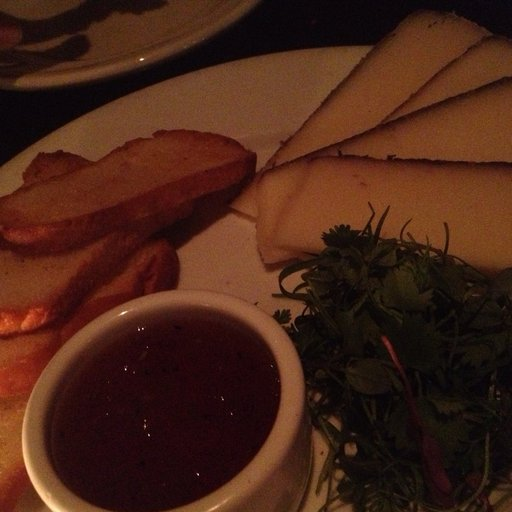

In [14]:
example_base_model_input[1]["content"][0]["image"]

In [15]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

# 1. Setup 4-bit config to save ~60-70% VRAM
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

# 2. Load model with quantization
model = AutoModelForImageTextToText.from_pretrained(
    MODEL_ID,
    quantization_config=quantization_config,
    device_map="auto",
    # Use flash_attention_2 if installed, else "sdpa"
    attn_implementation="sdpa",
)

# 3. Load processor with a constrained image size
processor = AutoProcessor.from_pretrained(MODEL_ID)
# Force smaller image patches to prevent token explosion
processor.image_processor.size = {"longest_edge": 512}

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.03G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/489 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/868 [00:00<?, ?B/s]

In [16]:
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

# Prepare model for 4-bit training
model = prepare_model_for_kbit_training(model)

peft_config = LoraConfig(
    r=16,
    lora_alpha=128,
    target_modules="all-linear", # Targets the necessary projection and attention layers
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 11,549,696 || all params: 519,032,000 || trainable%: 2.2252


In [17]:
# import torch
# from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

# print(f"Using model: {MODEL_ID}")

# model_kwargs = dict(
#     attn_implementation="eager",
#     dtype=torch.float16, # Changed from torch.bfloat16 to torch.float16
#     device_map="auto"
# )


# model = AutoModelForImageTextToText.from_pretrained(MODEL_ID,
#                                                     **model_kwargs)
# processor = AutoProcessor.from_pretrained(MODEL_ID)

In [18]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): SmolVLMForConditionalGeneration(
      (model): SmolVLMModel(
        (vision_model): SmolVLMVisionTransformer(
          (embeddings): SmolVLMVisionEmbeddings(
            (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
            (position_embedding): Embedding(1024, 768)
          )
          (encoder): SmolVLMEncoder(
            (layers): ModuleList(
              (0-11): 12 x SmolVLMEncoderLayer(
                (self_attn): SmolVLMVisionAttention(
                  (k_proj): lora.Linear4bit(
                    (base_layer): Linear4bit(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.05, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_features=16, bias=False)
                    )
                  

In [19]:
# Apply the chat template
example_chat_template_input = processor.apply_chat_template(
    [example_base_model_input[1]], # Note: if we are running this way, format the system_prompt to either be removed or folded into the user_prompt
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(device)

# Measure how long our input prompt is (our model will generate tokens *after* the input prompt)
input_len = example_chat_template_input["input_ids"].shape[-1]
print(f"[INFO] Input length: {input_len}")

# Perform inference with the base model
with torch.no_grad():
    generation_output_full = model.generate(**example_chat_template_input,
                                            max_new_tokens=256,
                                            do_sample=False)
    generation_output_short = generation_output_full[0][input_len:]

# Decode the outputs from tokens -> readable text
decoded_outputs = processor.decode(generation_output_short,
                                   skip_special_tokens=True)

# Print inputs and outputs
print("\n"+"-"*50+"\n")
print(f"[INFO] This is the raw token (numerical) intput to our model:\n")
print(example_chat_template_input["input_ids"][0])
print("\n"+"-"*50+"\n")
print(f"[INFO] This is the raw pixel values (numerical) intput to our model:\n")
print(example_chat_template_input["pixel_values"][0])
print("\n"+"-"*50+"\n")
print(f"[INFO] This is the input to our model in human-readable form (note: our model will not see in the input like this):\n")
print(processor.decode(example_chat_template_input["input_ids"][0]))
print("\n"+"-"*50+"\n")
print(f"[INFO] Outputs from the model:\n")
print(decoded_outputs)

[INFO] Input length: 250

--------------------------------------------------

[INFO] This is the raw token (numerical) intput to our model:

tensor([    1, 11126,    42, 49189, 49152, 49190, 49190, 49190, 49190, 49190,
        49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190,
        49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190,
        49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190,
        49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190,
        49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190,
        49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49189,
         8530,  1282,   260,  1836,  3007,  2443,   618,  1114,   355,   441,
          284,   585, 17748,  1114,   355,  5968,  3723,   359,  1386,    28,
         4930,   967,   288,   253,  1398,    30,  1094,   787,  1114,    31,
         6931,   900,  3723,   359,  6178,    28,  1003,  7964,  8639,    30,
 

In [20]:
# Freeze the vision backbone and only train the LLM parts
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = total - trainable
    return total, trainable, frozen

# Before freezing parameters
total_params, trainable_params, frozen_params = count_parameters(model)
print(f"[INFO] Params Total (before freezing the vision model): {total_params:,} | Params Trainable: {trainable_params:,} | Params Frozen: {frozen_params:,}")

# Freeze the vision encoder
for param in model.model.vision_model.parameters():
    # Turn off graidents in the vision model
    param.requires_grad = False

# After freezing parameters
total_params, trainable_params, frozen_params = count_parameters(model)
print(f"[INFO] Params Total (after freezing the vision model): {total_params:,} | Params Trainable: {trainable_params:,} | Params Frozen: {frozen_params:,}")

[INFO] Params Total (before freezing the vision model): 313,380,032 | Params Trainable: 11,549,696 | Params Frozen: 301,830,336


AttributeError: 'SmolVLMForConditionalGeneration' object has no attribute 'vision_model'

In [21]:
def convert_message_to_list_of_images(messages: list[dict]) -> list[Image.Image]:
    """Helper function to turn our message samples into lists of images.

    Note: this comes from here: https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora"""
    image_inputs = []

    # Iterate through each conversation
    for msg in messages:
        # Get content (ensure it's a list)
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and (
                "image" in element or element.get("type") == "image"
            ):
                # Get the image and convert to RGB
                if "image" in element:
                    image = element["image"]
                else:
                    image = element
                image_inputs.append(image.convert("RGB"))

    return image_inputs

def collate_fn(examples):
    """Helper function to stack together image + text pairs into batches."""

    # Create empty lists for batches of text and images
    texts = []
    images = []

    # Loop through examples and preprocess them
    for example in examples:
        image_inputs = convert_message_to_list_of_images(example["messages"])
        text = processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        )
        texts.append(text.strip())
        images.append(image_inputs)

    # Tokenize the texts and process the images
    batch_input = processor(text=texts,
                            images=images,
                            return_tensors="pt",
                            padding=True)

    # The labels are the input_ids and we mask the padding tokens and image tokens in the loss computation
    labels = batch_input["input_ids"].clone()

    # Get the image token
    image_token_id = processor.tokenizer.convert_tokens_to_ids("<image>")

    # Mask tokens for not being used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100 # pad_token_id = 2
    labels[labels == image_token_id] = -100 # image_token_id = 49190, this is the `<image>` token which is a placeholder, we don't need our model to learn to predict those

    batch_input["labels"] = labels

    return batch_input

# For SmolVLM2, check the image token
image_token_id = processor.tokenizer.convert_tokens_to_ids("<image>")
print(f"[INFO] SmolVLM2 uses the following for the image_token_id: {image_token_id}, we mask this token as it is only a placeholder in our sequence of tokens (we don't need the model to learn to predict it).")

[INFO] SmolVLM2 uses the following for the image_token_id: 49190, we mask this token as it is only a placeholder in our sequence of tokens (we don't need the model to learn to predict it).


In [22]:
from trl import SFTConfig

# Note: Many of these hyperparameters have been taken from the SmolDocling paper: https://arxiv.org/abs/2503.11576
training_args = SFTConfig(
    output_dir="smolvlm2-500m-FoodExtract-Vision-finetune",
    num_train_epochs=3, # depending on how much data you have you may want to train for shorter/longer
    per_device_train_batch_size=4, # adjust based on the size of your GPU
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=25,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    bf16=True,
    save_total_limit=1,
    max_grad_norm=1.0,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    push_to_hub=False,
    report_to="none",
    gradient_checkpointing_kwargs={
        "use_reentrant": False
    },
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
    load_best_model_at_end=True,
    remove_unused_columns = False
)

warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


In [23]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

In [26]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    # train_dataset=train_dataset[:1000],
    # eval_dataset=val_dataset[:50],
    train_dataset=train_dataset[:100], # Lowered for the video (faster)
    eval_dataset=val_dataset[:50], # Lowered for the video (faster)
    # peft_config=peft_config, # Note: We are not using PEFT but if we did, we could pass it in here
    processing_class=processor,
    data_collator=collate_fn
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.129330
2,No log,0.123762
3,No log,0.134415


TrainOutput(global_step=21, training_loss=0.08253656114850726, metrics={'train_runtime': 364.0698, 'train_samples_per_second': 0.824, 'train_steps_per_second': 0.058, 'total_flos': 328619676710400.0, 'train_loss': 0.08253656114850726})

In [29]:
trainer.save_model()

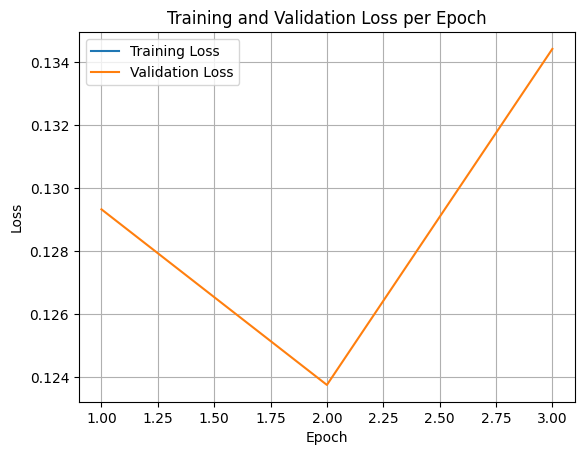

In [30]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
CHECKPOINT_DIR_NAME = training_args.output_dir
print(f"[INFO] Using fine-tuned checkpoint: {CHECKPOINT_DIR_NAME}")


[INFO] Using fine-tuned checkpoint: smolvlm2-500m-FoodExtract-Vision-finetune


In [32]:
from transformers import pipeline

# Load the base model (pt_pipe stands for "pretrained pipeline", 'pretrained model' is another word for 'base model'
pt_pipe = pipeline(
    "image-text-to-text",
    model=MODEL_ID,
    dtype=torch.bfloat16
)

# `do_sample = False` for deterministic responses
pt_pipe.model.generation_config.do_sample = False
pt_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id

# Load the fine-tuned model
ft_pipe = pipeline(
    "image-text-to-text",
    model=CHECKPOINT_DIR_NAME,
    dtype=torch.bfloat16
)

# `do_sample = False` for deterministic responses
ft_pipe.model.generation_config.do_sample = True
ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id

Loading weights:   0%|          | 0/489 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/489 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/594 [00:00<?, ?it/s]

In [33]:
pt_pipe.device, ft_pipe.device

(device(type='cuda', index=0), device(type='cuda', index=0))

[INFO] Example model input:
{'role': 'user', 'content': [{'type': 'image', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x790C340FD5E0>}, {'type': 'text', 'text': "Classify the given input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return empty lists.\n\nOnly return valid JSON in the following form:\n\n```json\n{\n  'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n  'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n  'food_items': [], # list[str] - list of visible edible food item nouns\n  'drink_items': [] # list[str] - list of visible edible drink item nouns\n}\n```\n"}]}

[INFO] Example model ideal output:
{'is_food': 0, 'image_title': '', 'food_items': [], 'drink_items': []}


Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[INFO] Generated output text from pre-trained model:
 [
]



Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



[INFO] Generated output text from fine-tuned model:
 {'is_food': 0, 'image_title': '', 'food_items': [], 'drink_items': []}

[INFO] Intput image:


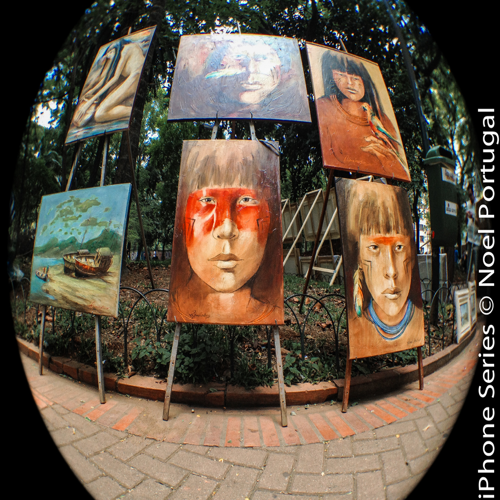

In [60]:
import random

# Pick a random sample from the validation dataset
random_val_sample = random.choice(val_dataset)
random_val_sample_model_input = random_val_sample["messages"][1]
random_val_sample_image = random_val_sample_model_input["content"][0]["image"]
random_val_sample_model_output = random_val_sample["messages"][-1]

# Print out the ideal input and outputs
print(f"[INFO] Example model input:\n{random_val_sample_model_input}")
print()
print(f"[INFO] Example model ideal output:\n{random_val_sample_model_output["content"][0]["text"]}")

# Perform a forward pass with the base model
pt_pipe_output = pt_pipe(text=[random_val_sample_model_input],
                         max_new_tokens=256)
pt_pipe_output_text = pt_pipe_output[0]["generated_text"][-1]["content"]
print(f"\n[INFO] Generated output text from pre-trained model:\n{pt_pipe_output_text}\n")

# Perform a forward pass with the fine-tuned model
ft_pipe_output = ft_pipe(text=[random_val_sample_model_input],
                         max_new_tokens=256)
ft_pipe_output_text = ft_pipe_output[0]["generated_text"][-1]["content"]
print(f"\n[INFO] Generated output text from fine-tuned model:\n{ft_pipe_output_text}\n")

print(f"[INFO] Intput image:")
random_val_sample_image.resize(size=(500, 500))